In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('survey.csv')
df.head()

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,2014-08-27 11:29:31,37,Female,United States,IL,NaN,No,Yes,Often,6-25,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NaN
1,2014-08-27 11:29:37,44,M,United States,IN,NaN,No,No,Rarely,More than 1000,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,NaN
2,2014-08-27 11:29:44,32,Male,Canada,NaN,NaN,No,No,Rarely,6-25,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NaN
3,2014-08-27 11:29:46,31,Male,United Kingdom,NaN,NaN,Yes,Yes,Often,26-100,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NaN
4,2014-08-27 11:30:22,31,Male,United States,TX,NaN,No,No,Never,100-500,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1259 entries, 0 to 1258
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Timestamp                  1259 non-null   object
 1   Age                        1259 non-null   int64 
 2   Gender                     1259 non-null   object
 3   Country                    1259 non-null   object
 4   state                      744 non-null    object
 5   self_employed              1241 non-null   object
 6   family_history             1259 non-null   object
 7   treatment                  1259 non-null   object
 8   work_interfere             995 non-null    object
 9   no_employees               1259 non-null   object
 10  remote_work                1259 non-null   object
 11  tech_company               1259 non-null   object
 12  benefits                   1259 non-null   object
 13  care_options               1259 non-null   object
 14  wellness

In [5]:
df.describe()

,Age
count,1.259000e+03
mean,7.942815e+07
std,2.818299e+09
min,-1.726000e+03
25%,2.700000e+01
50%,3.100000e+01
75%,3.600000e+01
max,1.000000e+11


In [6]:
missing_values = df.isnull().sum()
missing_values

,0
Timestamp,0
Age,0
Gender,0
Country,0
state,515
self_employed,18
family_history,0
treatment,0
work_interfere,264
no_employees,0


# cleaning

In [7]:
df.fillna({'work_interfere': 'Unknown'}, inplace=True)
df.dropna(subset=['Age', 'Gender', 'Country'], inplace=True)

In [8]:
# Normalize Gender column
def clean_gender(gender):
    gender = gender.lower()
    if 'male' in gender or gender == 'm':
        return 'Male'
    elif 'female' in gender or gender == 'f':
        return 'Female'
    else:
        return 'Other'

df['Gender'] = df['Gender'].apply(clean_gender)

In [9]:
df = df[(df['Age'] > 18) & (df['Age'] < 70)]

In [10]:
# Encode Yes/No columns
binary_cols = ['self_employed', 'family_history', 'treatment', 'tech_company',
               'benefits', 'care_options', 'wellness_program', 'seek_help',
               'anonymity', 'mental_health_consequence', 'phys_health_consequence']
df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)

<ipython-input-10-76592accb2ba>:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df[binary_cols] = df[binary_cols].applymap(lambda x: 1 if x == 'Yes' else 0)


# EDA

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

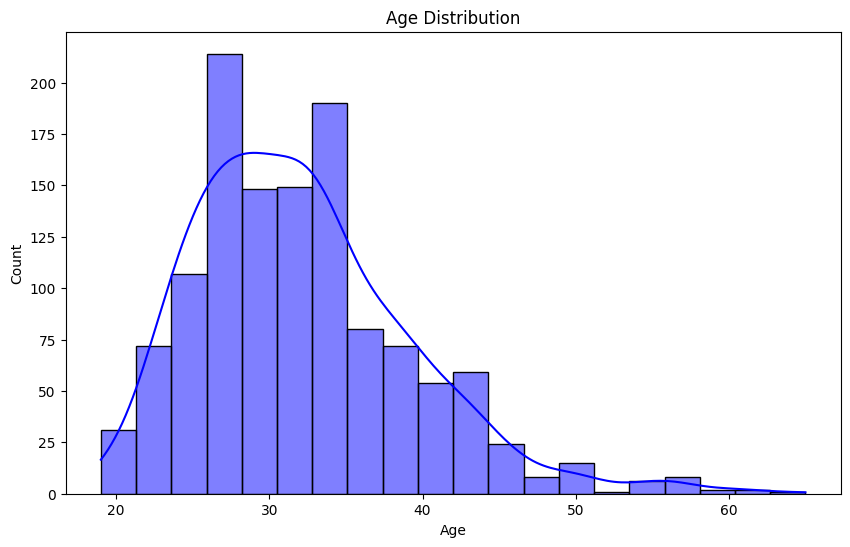

In [12]:
# Age distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Age'], bins=20, kde=True, color='blue')
plt.title('Age Distribution')
plt.show()

In [13]:
# Mental health treatment by country
top_countries = df['Country'].value_counts().head(10).index
country_df = df[df['Country'].isin(top_countries)]

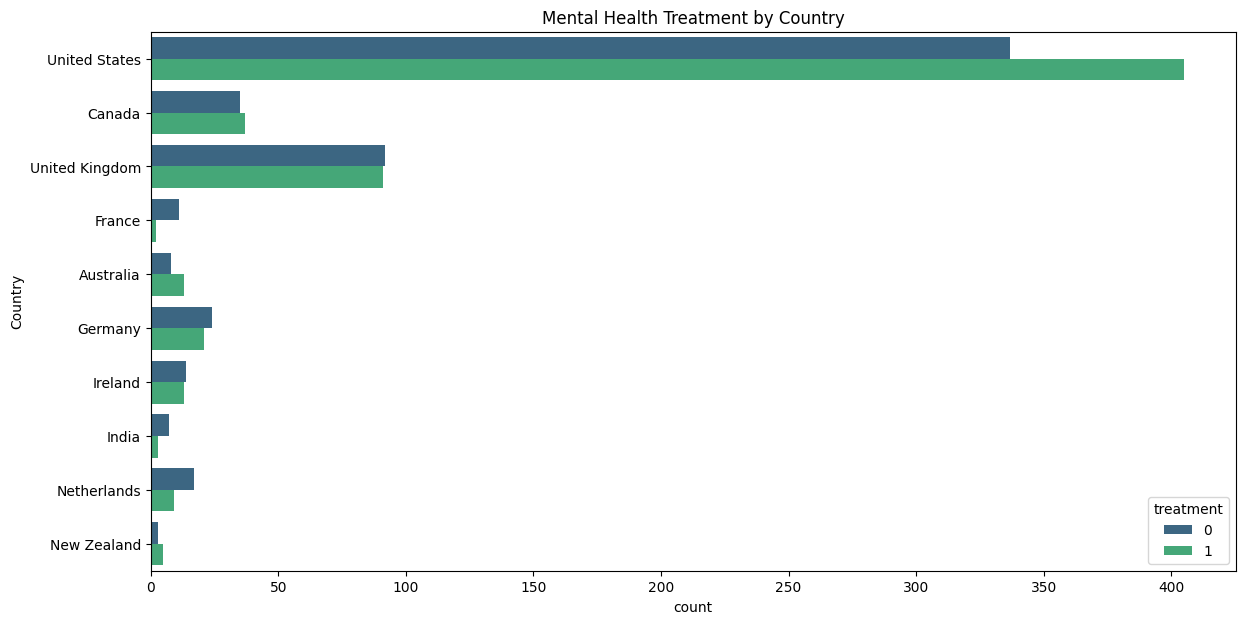

In [14]:
plt.figure(figsize=(14, 7))
sns.countplot(data=country_df, y='Country', hue='treatment', palette='viridis')
plt.title('Mental Health Treatment by Country')
plt.show()

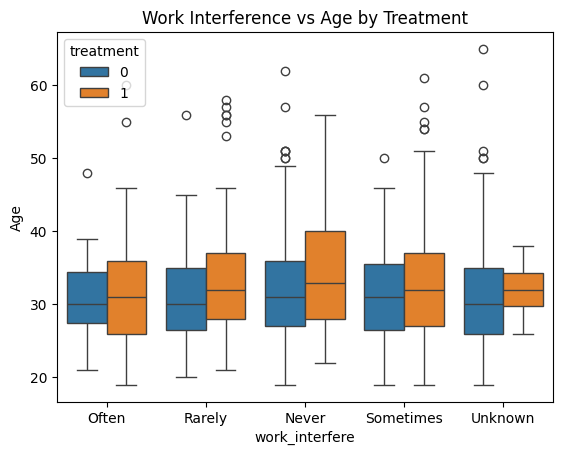

In [15]:
# Work interference vs Treatment
sns.boxplot(data=df, x='work_interfere', y='Age', hue='treatment')
plt.title('Work Interference vs Age by Treatment')
plt.show()

# Feature Engineering

In [16]:
# Create a Mental Health Index (example)
df['mental_health_index'] = df[['benefits', 'care_options', 'wellness_program']].sum(axis=1)

# Encode Work Interference
work_interfere_mapping = {'Never': 0, 'Rarely': 1, 'Sometimes': 2, 'Often': 3}
df['work_interfere_encoded'] = df['work_interfere'].map(work_interfere_mapping).fillna(0)


#  Predictive Modeling

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [19]:
# Define features and target
X = df[['Age', 'Gender', 'family_history', 'work_interfere_encoded', 'mental_health_index']]
X = pd.get_dummies(X, columns=['Gender'], drop_first=True)
y = df['treatment']


In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
# Train a Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [22]:
# Predictions and Evaluation
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.79      0.77       124
           1       0.78      0.75      0.77       125

    accuracy                           0.77       249
   macro avg       0.77      0.77      0.77       249
weighted avg       0.77      0.77      0.77       249



In [23]:
# Feature Importance
importances = model.feature_importances_
for name, importance in zip(X.columns, importances):
    print(f'{name}: {importance}')

Age: 0.28894993967622234
family_history: 0.10621292815464502
work_interfere_encoded: 0.49243375514626053
mental_health_index: 0.09419729280131667
Gender_Male: 0.012876580669755963
Gender_Other: 0.005329503551799659


#Results

In [24]:
import plotly.express as px

# Interactive Treatment by Country Plot
fig = px.bar(country_df, x='Country', y='treatment', color='treatment',
             title='Mental Health Treatment by Country', barmode='group')
fig.show()